In [2]:
from fastai.vision.all import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import timm

In [3]:
# Import the dataset
csv_file_2 = '../data/raw/tmidata_000_cv_splits_img.csv'
df = pd.read_csv(csv_file_2)

In [4]:
import torch

# Check if GPU is available and being used
if torch.cuda.is_available():
    print('Using GPU:', torch.cuda.get_device_name(torch.cuda.current_device()))
else: 
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3060 Ti


In [5]:
# Add 'image_path' column that includes complete path to the images
df['image_path'] = df['imgs'].apply(lambda x:'../data/raw/PNAS-images/' + x)

In [6]:
trn_path = '../data/raw/PNAS-images/'
files = get_image_files(trn_path)

(1024, 1024)


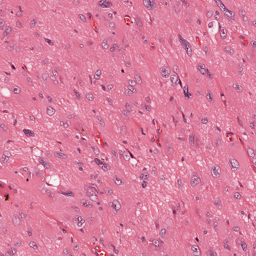

In [7]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(256)

In [8]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=0) # multiprocessing isn't available... 
pd.Series(sizes).value_counts()

(1024, 1024)    1505
Name: count, dtype: int64

All images are the same size (1024, 1024).

In [9]:
df['Histomolecular subtype'].unique()

array(['idhwt_ATC', 'idhmut_ATC', '1.0', 'ODG'], dtype=object)

Brain tumor types:
* idhwt_ATC: IDH-wildtype anaplastic astrocytoma. 
    * Agressive and poorer prognosis.
* idhmut_ATC:IDH-mutant anaplastic astrocytoma. 
    * Generally less aggressive and better prognosis compared to IDH-wildtype.
* 1.0: ? No idea
* ODG: Oligodendroglioma.
    * The cells responsible for producing myelin in the brain.
    * More favorable prognosis and better response to treatment.

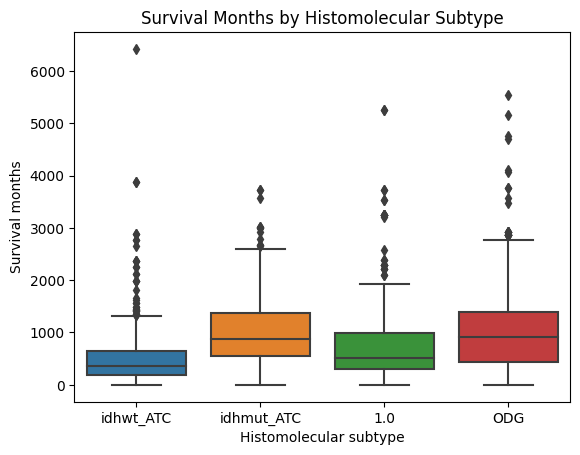

In [10]:
plt.figure()
sns.boxplot(x='Histomolecular subtype', y='Survival months', data=df)
plt.title('Survival Months by Histomolecular Subtype')
plt.show()

In [11]:
summary_stats = df.groupby('Histomolecular subtype')['Survival months'].describe()
print (summary_stats)

                        count         mean         std  min     25%    50%   
Histomolecular subtype                                                       
1.0                     394.0   768.263959  773.325150  0.0  301.00  514.0  \
ODG                     361.0  1069.432133  968.762120  2.0  431.00  908.0   
idhmut_ATC              178.0  1062.707865  773.264080  3.0  548.75  868.0   
idhwt_ATC               572.0   518.159091  574.631475  3.0  178.75  368.5   

                           75%     max  
Histomolecular subtype                  
1.0                      992.0  5255.0  
ODG                     1382.0  5546.0  
idhmut_ATC              1375.0  3725.0  
idhwt_ATC                637.5  6423.0  


In [12]:
# Split data into training and validation sets
train_df = df.sample(frac=0.8, random_state=42)
valid_df = df.drop(train_df.index)

In [13]:
print('Shape of train_df: ', train_df.shape)
print('Shape of valid_df: ', valid_df.shape)

Shape of train_df:  (1204, 24)
Shape of valid_df:  (301, 24)


In [14]:
# Create ImageDataLoaders
dls = ImageDataLoaders.from_df(train_df, path='', fn_col='image_path', label_col='Histomolecular subtype',
                               item_tfms=Resize(480, method='squish'), 
                               batch_tfms=aug_transforms(do_flip=True,
                                                         flip_vert=True,
                                                         max_rotate=360,
                                                         max_lighting=0.2,
                                                         max_zoom=1.0,
                                                         max_warp=0.0,
                                                         p_affine=1.0,
                                                         p_lighting=1.0,
                                                         xtra_tfms=[RandomResizedCrop(size=(460, 460), 
                                                                                      min_scale=0.75,
                                                                                      max_scale=1.0,
                                                                                      ratio=(1,1))]
                                                         
                                                        ), 
                               y_block=CategoryBlock, bs=32,
                               spltter=lambda x: x.index.inin(valid_df.index)
                             )

In [15]:
?aug_transforms

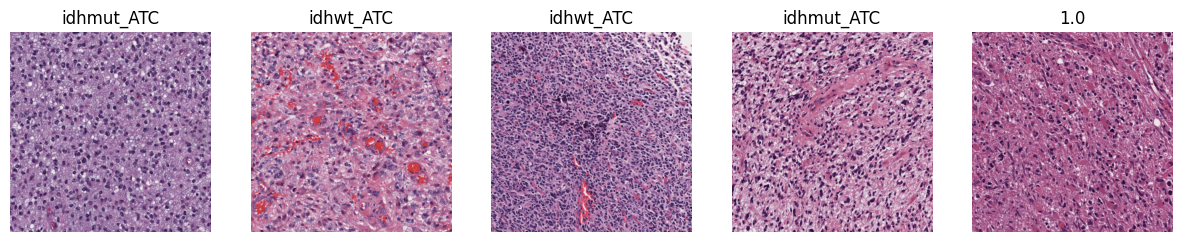

In [16]:
dls.valid.show_batch(max_n=5, nrows=1)

# First model

In [20]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

SuggestedLRs(valley=0.0020892962347716093)

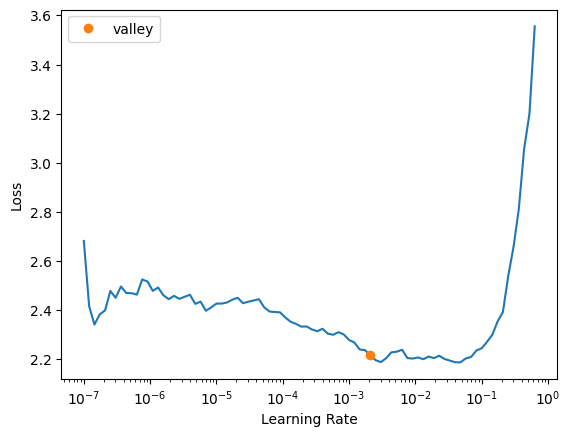

In [21]:
learn.lr_find()

In [23]:
learn.fine_tune(3,0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.174235,2.084789,0.500000,00:49


epoch,train_loss,valid_loss,error_rate,time
0,1.143570,1.171812,0.425000,00:49
1,1.070986,1.352022,0.425000,00:48
2,0.981345,1.197077,0.441667,00:49


In [24]:
# Save the trained model
learn.save('model')

Path('models/model.pth')